In [126]:
from importlib import reload
import os 
import pathlib
import sys
sys.path.append('..')

# import kerchunk
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import dask
from dask.distributed import Client
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import s3fs
import datetime as dt

import logging
import fsspec
import ujson
# from tqdm import tqdm_notebook as tqdm
from glob import glob
import seaborn as sb

from src import processing as pr
from src import zarr_access as za
reload(pr)
reload(za)

<module 'src.zarr_access' from '/Users/geet/Documents/Repositories/Owned/goesdata/notebooks/../src/zarr_access.py'>

# Performance

## Option-1 

On a local Macbook Pro M1, for around a network speed fluctuating between 30-80 MB/s, getting a mapper for a whole day worth of files (for C13 of ABI-L2-CMPIPF) took around 11:41 minutes. Also, processing (e.g. subsampling (22.7s) and plotting (8.5s)) takes longer with a mapper including so many files. 

## Option-2

__N.B. Numbers in parantheses show values for different instances of running the code__

For roughly the same parameters as above, an hour's worth of files took around (35.6,24.3) seconds. Extrapolating that to 24 hours, brings us to a total time of 14 minutes, which suggests that a whole day's mapper might be better than going hourly. However, processing (subsampling (7.5s,8.1s) and plotting (0.5s,0.6s)) is much quicker. 

## Conclusion?

- Subsampling would usually only be done once, so it doesn't make a big difference here.
- But if your goal is to make plots for the whole day every 10 minutes... 
  - **Option-1** would take 11:41 + (8.5*24*6/60 = 20.4) ~ **30 minutes**, whereas
  - **Option-2** would take (24.3x24/60 = 9.7,35.6x24/60 = 14.24) + (0.5x24x6/60 = 1.2,0.5x24x6/60 = 1.44) ~ **15.44, 10.9 minutes**

Do what you want with that bit of super-rigorous performance testing! /s

In [145]:
hour = 17
year = 2021
dayofyear = 324
channel = 13
product = 'ABI-L2-CMIPF'  #'ABI-L1b-RadF' 
satellite = 'goes16' #'goes17'

gs = za.generate_globsearch_string(year, dayofyear, hour)
flist = za.generate_url_list(gs)
m = za.get_mapper_from_mzz(flist)

In [129]:
time = "20200124 16:07:05"
format = "%Y%m%d %H:%M:%S"

flist= za.nearest_time_url(time,format)
m = za.get_mapper_from_mzz(flist)

/Users/geet/Documents/Repositories/Owned/goesdata/goesdata_env/lib/python3.10/site-packages/kerchunk/combine.py:269: UserWarning: Concatenated coordinate 't' contains less than expectednumber of values across the datasets: [6.33154502e+08]
  warnings.warn(


In [146]:
img = pr.Image(m)
extent = (-58,-48,10,20)

subset = img.subset_region_from_latlon_extents(extent, unit="degree")

/Users/geet/Documents/Repositories/Owned/goesdata/notebooks/../src/processing.py:28: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  self.dataset = xr.open_dataset(filepath, engine="zarr")
/Users/geet/Documents/Repositories/Owned/goesdata/notebooks/../src/processing.py:178: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - (4 * a * c))) / (2 * a)


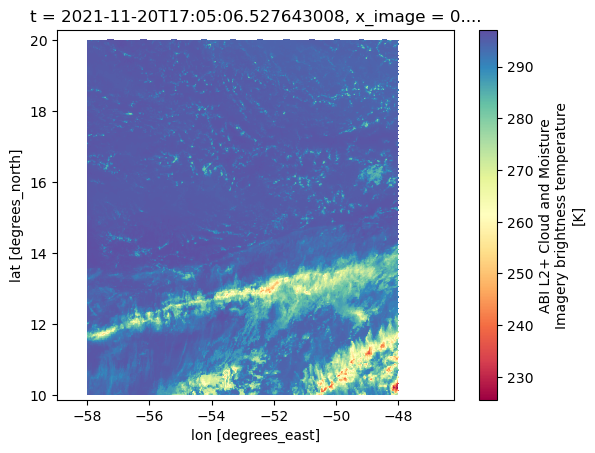

In [149]:
subset.CMI.isel(t=0).plot(x='lon',y='lat',cmap='Spectral')